In [1]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# retrieve data and store it in a dataframe
df = pd.read_csv('accent-mfcc-data-1.data', header=None)
y = np.array(df.iloc[:,0])

# get unique classification labels
uniq_labels = np.unique(y)
labels = {}
for i in range(0,len(uniq_labels)):
    labels[uniq_labels[i]] = i

# centre the data and store in a numpy array
df.drop(0, inplace=True, axis=1)
for i in df:
    df[i] = (df[i] - df[i].mean())
X = df.to_numpy()

In [3]:
# return the top principal components requested (data should be centred before passing as parameter)
def getPC(data, numOfPCs):
    U,S,V = np.linalg.svd(data, full_matrices=True)
    V = V[0:numOfPCs]
    return V

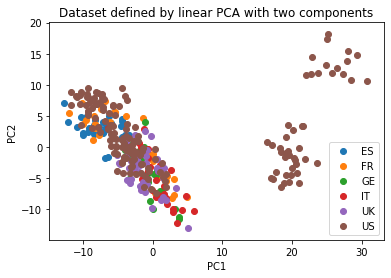

In [4]:
# get the top 2 principal components and calculate their representation of each feature vector
top2PCs = getPC(X, 2)
top2X = np.matmul(X, np.transpose(top2PCs))

# separate the feature vectors by their classes and store in a dictionary (where each key represents a class of the dataset)
separatedByClass = {}
for i in range(0, len(top2X)):
    if y[i] in separatedByClass:
        separatedByClass[y[i]].append(top2X[i])
    else:
        separatedByClass[y[i]] = [top2X[i]]
        
# separate the x and y value of each class, and plot it on a scatter plot
for i in separatedByClass:
    xToPlot = np.array(separatedByClass[i])[:, 0]
    yToPlot = np.array(separatedByClass[i])[:, 1]
    plt.scatter(xToPlot,yToPlot,label=i)
plt.legend(loc='lower right')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Dataset defined by linear PCA with two components')
plt.show()

##  Discussions explaining if the dataset is linearly separable in 2d after visual inspection
Linear separability in 2d is where distinct classes of data plotted on a set of axes can be divided by drawing (n-1) linear lines such that two points of the same class are not in the same segregated cluster (after the lines have been drawn). In this case, as there are 6 classes, if linear separability was possible, 5 lines would need to be used to divide the data such that no two points of the same class are in the same cluster. As shown when running the above cell, when plotting the dataset in a 2d feature space defined by linear PCA (i.e. getting the top 2 principal components of the dataset and plotting it as a scatter graph), the dataset is not linearly separable in 2d after visual inspection. This is clear as there is no (linear) line that can be drawn through the left-most cluster of the graph above that separates points of a particular class from points corresponding to other classes. Therefore the data is not linearly separable after visual inspection. There are 3 distinct clusters, and although two consist of the same accent and can be separated from the third cluster, the third cluster (on the left) still contains data points of the accent from the other two clusters, therefore there is no line that can separate the data points in the data points from the left-most cluster to be in the same separated space as the two right-most cluster, hence this is another way the dataset is not linearly separable in 2d after visual inspection.

In [5]:
# method that returns a set of weights to classify feature vectors in X
# takes a set of feature vectors X, a set of classifications for each feature vector y, and a set of weights w
# returns a refined set of weights
def multiClassPerceptron(X,y,w):
    w_copy = w.copy()
    # we are given that the perceptron must run for 10 iterations/epochs
    for i in range(0,10):
        X_shuffle, y_shuffle = shuffle(X, y)
        # for each example, classify it by choosing the index that maximises the numerical value given by each class' weight 
        # multiplied by the feature vector
        for j in range(0,len(X_shuffle)):
            maxClassIndex = np.argmax(np.matmul(w_copy,X_shuffle[j]))
            # if the example is misclassified, add the example's values to the correct label, and subtract from the predicted
            # label to encourage a larger value for the correct label the next time a similar example is found
            if maxClassIndex != labels[y_shuffle[j]]:
                w_copy[labels[y_shuffle[j]]] += X_shuffle[j]
                w_copy[maxClassIndex] -= X_shuffle[j]
    return w_copy

# method to test the accuracy of the perceptron - takes set of feature vectors X, classifications y, and a set of weights w
# returns the number of classification errors
def testPerceptron(X,y,w):
    numErrors = 0
    # go through each example, get the index of the likeliest accent according to the weight vector
    for i in range(0,len(X)):
        maxClassIndex = np.argmax(np.matmul(w,X[i]))
        # if the accent predicted is incorrect, increment a counter for the number of errors
        if maxClassIndex != labels[y[i]]:
            numErrors += 1
    return numErrors

In [8]:
# this cell tests whether the dataset is linearly separable using the datset itself

# first create the set of weights with a bias (of 0)
w = np.zeros((len(uniq_labels),X.shape[1]+1))

# add a bias of 1 for each example in the dataset
ones = np.ones((len(X),1))  
XBias = np.hstack((ones,X))
# calculate the weights using the multiclass perceptron, then count the number of errors when classifying using those weights
w = multiClassPerceptron(XBias,y,w)
numOfErrors = testPerceptron(XBias,y,w)
# calculate the success percentage and display to the user
percentage = np.round(np.round((len(X)-numOfErrors)/len(X),4)*100,2)
print("Original dataset: " + "Correctly Classified: " + str(percentage) + "%")

Original dataset: Correctly Classified: 73.25%


##  Discussions explaining if the dataset is linearly separable in the original feature space

As shown when running the above cell, when the perceptron is run using the original dataset (with a bias), the set of weights that are returned do not result in 100% classification success, therefore the dataset is not linearly separable in the original feature space. We know that the dataset isn't linearly separable due to the fact that the percentage above is lower than 100%, therefore according to the perceptron, the dataset is not linearly separable in the original feature space. The accuracy of the perceptron using the original feature space ranges from roughly 65-75% after 10 iterations of the perceptron.

In [9]:
# this cell tests whether the dataset is linearly separable using linear PCA
for i in range(2,13):
    # for each PC value, get the top i PCs and get their projection of X using the top i PCs
    topPCs = getPC(X, i)
    topX = np.matmul(X, np.transpose(topPCs))
    # create the set of weights with a bias (of 0)
    w = np.zeros((len(uniq_labels),topX.shape[1]+1))
    # add a bias of 1 for each example in the dataset
    ones = np.ones((len(topX),1))  
    XBias = np.hstack((ones,topX))
    # calculate the weights using the multiclass perceptron, then count the number of errors when classifying using those weights
    w = multiClassPerceptron(XBias,y,w)
    numOfErrors = testPerceptron(XBias,y,w)
    # calculate the success percentage and display to the user
    percentage = np.round(np.round((len(X)-numOfErrors)/len(X),4)*100,2)
    print(str(i) + " PCs: " + "Correctly Classified: " + str(percentage) + "%")

2 PCs: Correctly Classified: 44.68%
3 PCs: Correctly Classified: 51.98%
4 PCs: Correctly Classified: 56.23%
5 PCs: Correctly Classified: 59.27%
6 PCs: Correctly Classified: 47.11%
7 PCs: Correctly Classified: 62.61%
8 PCs: Correctly Classified: 55.62%
9 PCs: Correctly Classified: 62.31%
10 PCs: Correctly Classified: 68.09%
11 PCs: Correctly Classified: 67.17%
12 PCs: Correctly Classified: 73.56%


## Discussions explaining if the dataset is linearly separable in the feature space defined by linear PCA
As shown when running the above cell, when the perceptron is run using linear PCA between 2 and 12 PCs (2 is the minimum number of PCs as this is given in the coursework specification, and 12 is the maximum as this is the total number of features in the dataset therefore the maximum number of principal components), the set of weights that are returned do not result in 100% classification success (using linear PCA), therefore the dataset is not linearly separable using linear PCA. As the number of PCs increase, the accuracy of the perceptron also increases, however it doesn't reach 100% after 10 iterations of the perceptron (as shown in the results before), therefore the dataset is not linearly separable using linear PCA.  Therefore there is not a minimum number of top principal components that lead to the dataset being linearly separable using linear PCA. The lowest percentage of classified examples tends to be using two principal components and often leads to a 30-40% classifcation accuracy, whereas the number of PCs which classifies the most examples successfully tends to be 12 PCs, often achieving an accuracy of 65-70%.

In [10]:
# function to normalise the kernel matrix
def normaliseKernel(K):
    A = np.full((len(K),len(K)), (1/len(K)))
    return (K - np.matmul(A,K) - np.matmul(K,A) + np.matmul(np.matmul(A,K),A))

# implement the kernel matrix using radial basis function Kernel
def rbfKernel(X, gamma):
    X_norm = np.sum(X ** 2, axis = -1)
    return normaliseKernel(np.exp(-gamma * (X_norm[:,None] + X_norm[None,:] - 2 * np.dot(X, X.T))))

# do kernel PCA
def kernelPC(K, numPCs):
    V = getPC(K,numPCs)
    return np.matmul(K, np.transpose(V))

In [11]:
# calculate the minimum and maximum value of gamma using the features variances
minVar = math.inf
maxVar = -math.inf
epsilon = 0.05
for i in range(0,X.shape[1]):
    if np.var(X[:,i]) < minVar:
        minVar = np.var(X[:,i])
    if np.var(X[:,i]) > maxVar:
        maxVar = np.var(X[:,i])
        
minGamma = 1/(2*(maxVar+epsilon))
maxGamma = 1/(2*(minVar+epsilon))

In [12]:
# set hyperparameter of increment value, and get range of gamma values to test
incrementValue = 0.01
gammas = np.arange(minGamma,maxGamma,incrementValue)
gammas = np.append(gammas,maxGamma)
arr = []
arr2 = []
# iterate over all PC values, and all gamma values
for i in range(1,len(X)+2):
    for j in gammas:
        # calculate kernel matrix values and perform kernel PCA on the returned kernel matrix
        kernelMat = rbfKernel(X,j)
        topX = kernelPC(kernelMat, i)
        # use the perceptron on the projection of the kernel matrix, and count how many errors there are using the perceptron's weights
        w = np.zeros((len(uniq_labels),topX.shape[1]+1))
        ones = np.ones((len(topX),1))
        XBias = np.hstack((ones,topX))
        w = multiClassPerceptron(XBias,y,w)
        numOfErrors = testPerceptron(XBias,y,w)
        arr.append(numOfErrors)
        # if the perceptron's weights correctly classify the dataset, print the PC value and gamma value
        if numOfErrors == 0 and i <= len(X):
            print("PCs: " + str(i) + "   Gamma: " +str(j) + "   Num Errors: " + str(numOfErrors))
    arr2.append(arr)
    arr = []

PCs: 281   Gamma: 0.08061808417247461   Num Errors: 0
PCs: 291   Gamma: 0.06920499723800104   Num Errors: 0
PCs: 294   Gamma: 0.07920499723800103   Num Errors: 0
PCs: 295   Gamma: 0.05920499723800104   Num Errors: 0
PCs: 295   Gamma: 0.07920499723800103   Num Errors: 0
PCs: 296   Gamma: 0.049204997238001036   Num Errors: 0
PCs: 296   Gamma: 0.05920499723800104   Num Errors: 0
PCs: 296   Gamma: 0.08061808417247461   Num Errors: 0
PCs: 298   Gamma: 0.08061808417247461   Num Errors: 0
PCs: 299   Gamma: 0.07920499723800103   Num Errors: 0
PCs: 300   Gamma: 0.08061808417247461   Num Errors: 0
PCs: 301   Gamma: 0.08061808417247461   Num Errors: 0
PCs: 306   Gamma: 0.07920499723800103   Num Errors: 0
PCs: 311   Gamma: 0.06920499723800104   Num Errors: 0
PCs: 314   Gamma: 0.07920499723800103   Num Errors: 0
PCs: 314   Gamma: 0.08061808417247461   Num Errors: 0
PCs: 315   Gamma: 0.07920499723800103   Num Errors: 0
PCs: 315   Gamma: 0.08061808417247461   Num Errors: 0
PCs: 316   Gamma: 0.0692049

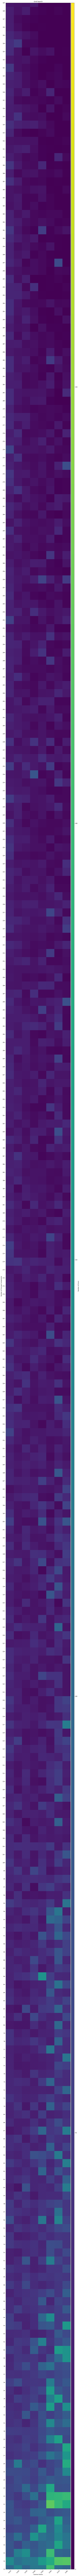

In [14]:
# form the x and y ticks to populate the axes
xticks = np.append(np.round(np.array(np.arange(minGamma-incrementValue,maxGamma,incrementValue)),3), np.round(maxGamma,3))
yticks = np.arange(13, len(X)+1)
plt.figure(figsize = (10,500))
# set the title and axes labels
plt.title('Grid Search')
plt.xlabel('Gamma Values')
plt.ylabel('Number of Principal Components')
# set the axes limits (13 as this is the minimum number of PCs requested) and replace the x and y ticks with those calculated above
ax = plt.gca()
ax.set_ylim([13, len(X)])
ax.set_xticklabels(xticks,rotation=45)
ax.set_yticks(np.array(np.arange(13,len(X)+1)))
ax.set_yticklabels(yticks)
# add the colourbar to the grid search and display the grid search 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
a = plt.colorbar(ax.imshow(arr2,origin='lower'), cax=cax, orientation='vertical',label='Number of Errors')

## Discussions explaining if the dataset is linearly separable in the feature space defined by non-linear PCA
As shown when running the above two cells, when the perceptron is run using non-linear PCA between 13 and 329 PCs (13 is the minimum number of PCs as this is given in the coursework specification, and 329 is the maximum as this is the maximum dimension of the radial basis function kernel), the set of weights that are returned do result in 100% classification success (depending on the number of principal components being checked), therefore the dataset is linearly separable using non-linear PCA. We can see that the perceptron classifies with 100% accuracy by using the grid search. This is because the darkest purple implies that the weights returned by the perceptron lead to 0 classification errors (as shown by the colour bar). All the principal component-gamma pairs that result in no classification errors are printed for the user to see alongside the grid search. The minimum number of PCs ranges between 270-290 depending on how the dataset is shuffled (this changes every time the cell is run), with the gamma value mostly being either 0.0692, 0.0792, or 0.0806. In the latest execution of the cell above, the minimum number of principal components required for linear separability is 281 with a gamma value of 0.0806 (4 dp) (see output of cell two cells above). The lowest number of PCs that has been seen that has linearly separated the dataset (i.e. 0 classification errors) using non-linear PCA and this perceptron is 269 with a gamma value of 0.0792 (4dp).